# Sentence Mapper Ideas Testing

In [1]:
%load_ext autoreload
%autoreload 2

import json
from src.pipeline import SentenceMapperPipeline
from src.visualization import SentenceMapperVisualizer
from src.powerlaw_optimizer import fit_frontier_curve
from src.sentence_processor import SentenceProcessor

In [2]:
def load_jsonl_example(file_path: str, index: int = 0) -> dict[str, str]:
    """Load a specific example from a JSONL file.

    Args:
        file_path: Path to the JSONL file
        index: Index of the example to load (default: 0)

    Returns:
        Dictionary with keys: id, pid, input, output
    """
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i == index:
                return json.loads(line)
    raise IndexError(f"Index {index} not found in file")

Document ID: crs_R40833
Total chunks: 35
Total sentences: 342
Total tokens: 12614


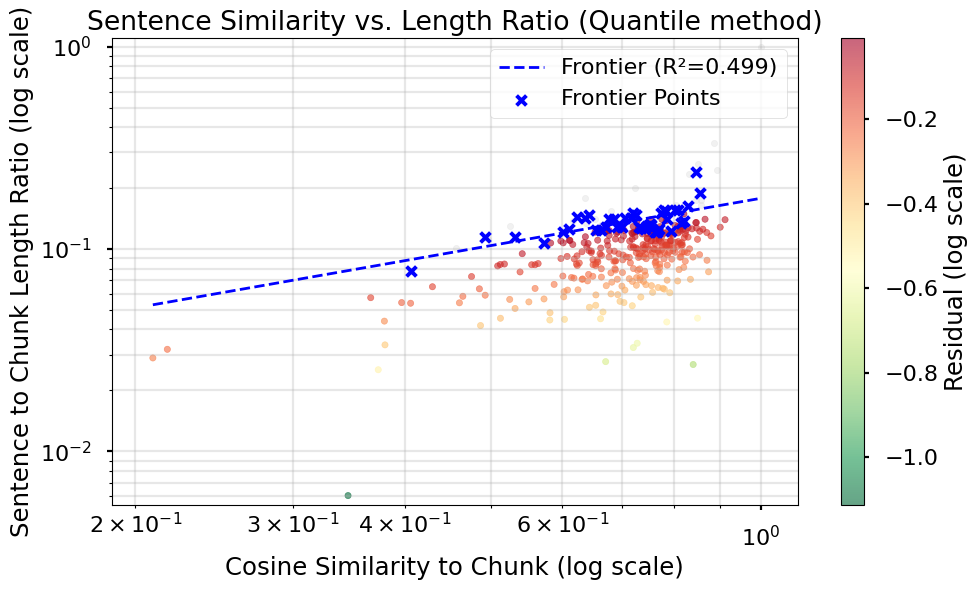

In [8]:
# Load data
data = load_jsonl_example(
    "data/gov_report/train.jsonl",
    index=1
)

processor = SentenceProcessor(
    embedding_model_name="minishlab/potion-base-8M",
    chunk_size=2048,
    chunk_overlap=0,
    min_sentence_length=256,
)
features = processor.compute_document_features(
    text=data["input"],
)

print(f"Document ID: {data['id']}")
print(f"Total chunks: {len(features['chunks'])}")
print(f"Total sentences: {len(features['all_similarities'])}")
print(f"Total tokens: {features['total_tokens']}")

slope, intercept, info = fit_frontier_curve(
    features['all_similarities'],
    features['ratios'],
    quantile=0.95,
    # n_bins=20,
    method='quantile'
)

visualizer = SentenceMapperVisualizer(
    slope=slope,
    initial_intercept=intercept
)

visualizer.plot_with_frontier(
    similarities=features['all_similarities'],
    ratios=features['ratios'],
    slope=slope,
    intercept=intercept,
    info=info,
    title=f"Sentence Similarity vs. Length Ratio (Quantile method)",
)


In [4]:
# Initialize pipeline
pipeline = SentenceMapperPipeline(
    embedding_model_name="minishlab/potion-base-8M",
    chunk_size=2048,
    chunk_overlap=0,
    min_sentence_length=256,
)

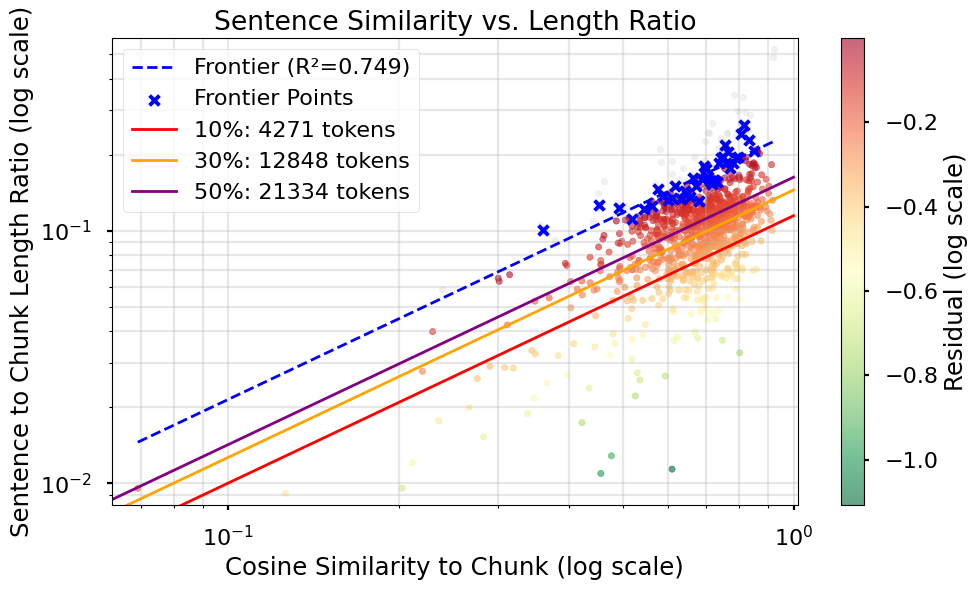

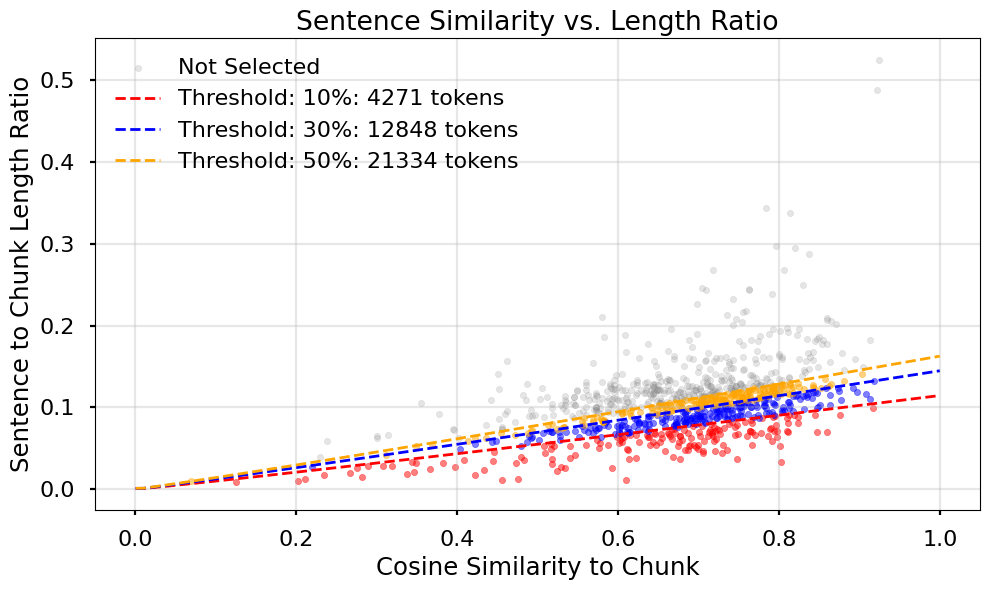

In [5]:
results = []
for objective in [0.1, 0.3, 0.5]:
    result = pipeline.process_document(
        text=data["input"],
        objective_percentage=objective,
    )
    results.append(result)


visualizer.plot_with_frontier(
    similarities=results[-1]['all_similarities'],
    ratios=results[-1]['ratios'],
    slope=slope,
    intercept=intercept,
    info=info,
    x_opt=[result['x_opt'] for result in results],
    labels=[f"{int(objective*100)}%: {result['selected_tokens']} tokens" for objective, result in zip([0.1, 0.3, 0.5], results)],
    title=f"Sentence Similarity vs. Length Ratio"
)

visualizer.plot_similarity_vs_ratio(
    similarities=features['all_similarities'],
    ratios=features['ratios'],
    mask = [result['mask'] for result in results],
    x_opt= [result['x_opt'] for result in results],
    labels=[f"{int(objective*100)}%: {result['selected_tokens']} tokens" for objective, result in zip([0.1, 0.3, 0.5], results)],
    title="Sentence Similarity vs. Length Ratio",
)

In [6]:
result = pipeline.process_document(
    text=data["input"],
    objective_percentage=0.1,
)

visualizer.export_highlighted_text(
    sentences=result['sentences'],
    mask=result['mask'],
    output_path=f"data/img/{data['id']}_{0.1*100:.0f}.html"
)

In [7]:
visualizer.plot_with_frontier_interactive(
    similarities=results[-1]['all_similarities'],
    ratios=results[-1]['ratios'],
    slope=slope,
    intercept=intercept,
    info=info,
    sentences=results[-1]['sentences'],  # List of sentence texts
    x_opt=[0.3, 0.5],  # Optional threshold curves
    labels=["30%", "50%"],  # Optional labels
    save_path="output.html",  # Saves as interactive HTML
)

IndexError: list index out of range